# Prepare Raster Data

#### Overview
This notebook provides code to create the raster data used in the rest of the analysis. The raster data processed here must be downloaded from the GRIDCERF database. 

The following rasters are created from this notebook

## Download Required Datasets

### Siting Suitability Data (GRIDCERF)

Download the GRIDCERF package from here: https://doi.org/10.57931/2281697. Please extract GRIDCERF inside the `/data/input_data/` directory of this repository as the paths in this notebook are set to that expectation.

Dataset Title: Geospatial Raster Input Data for Capacity Expansion Regional Feasibility

Download: https://doi.org/10.57931/2281697

Reference:
>
______________

### Renewable Capacity Factor Data 

Download the following capacity factor datasets extract them inside the `/data/input_data/renewable_capacity_factor_data` directory of this repository as the paths in this notebook are set to that expectation.

**NOTE:** Both of the solar and wind capacity factor files are considerably large and require > 29.4 GB of storage. Downloading these files may take some time.


Dataset Title: Hourly Wind and Solar Generation Profiles at 1/8th Degree Resolution - solar rcp85hotter 2020-2059 (v1.0.0)

Download: https://zenodo.org/records/10140686

Reference:
> Bracken, C., Thurber, T., & Voisin, N. (2023). Hourly Wind and Solar Generation Profiles at 1/8th Degree Resolution - solar rcp85hotter 2020-2059 (v1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10140686


Dataset Title: Hourly Wind and Solar Generation Profiles at 1/8th Degree Resolution - wind 100m rcp85hotter 2040-2059 (v1.0.0)

Download: https://zenodo.org/records/10152946

Reference:
> Bracken, C., Thurber, T., & Voisin, N. (2023). Hourly Wind and Solar Generation Profiles at 1/8th Degree Resolution - wind 100m rcp85hotter 2040-2059 (v1.0.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10152946

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from scipy.ndimage import maximum_filter
import numpy as np
import os
from tqdm import tqdm
import xarray as xr
import rioxarray
from glob import glob
import salem

#### Directories and Data Paths

In [4]:
# data directory
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')

#data directory with raw gridcerf data
#gridcerf_dir = os.path.join(data_dir, 'input_data', 'gridcerf', 'data')
gridcerf_dir = '/Users/mong275/repos/gridcerf/data/gridcerf'

# tech_specific dir
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# GRIDCERF technology_specific data directory
common_dir = os.path.join(gridcerf_dir, "common")

# GRIDCERF compiled final suitability data directory
compiled_dir = os.path.join(gridcerf_dir, "compiled_technology_layers")

# GRIDCERF compiled final suitability data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF land mask raster with land = 0
land_mask_file_0 = os.path.join(reference_dir, "gridcerf_landmask_0-land.tif")

# GRIDCERF land mask raster with land = 1
siting_mask_file_1 = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# renewable generation directories
solar_cf_dir = os.path.join(data_dir, 'input_data', 'renewable_capacity_factor_data', 'solar_rcp85hotter_2020_2059')
wind_cf_dir = os.path.join(data_dir, 'input_data', 'renewable_capacity_factor_data', 'wind_rcp85hotter_2040_2059')                           

# processed raster dir
processed_raster_dir = os.path.join(data_dir, 'input_data', 'compiled_raster_data')

# analysis raster data dir
raster_output_dir = os.path.join(data_dir, "input_data", 'west_raster_data')

# raster output for land only files
land_raster_output_dir = os.path.join(raster_output_dir, 'land_area')
os.makedirs(land_raster_output_dir, exist_ok=True)

# raster output for all area files
all_area_raster_output_dir = os.path.join(raster_output_dir, 'all_area')
os.makedirs(all_area_raster_output_dir, exist_ok=True)

# path to western interconnection shapefile to clip rasters by
wecc_land_shp_path =  os.path.join(data_dir, 'input_data', "wecc_boundary_shp", "wecc_boundary.shp")

# western interconnection shapefile, includes ocean area
wecc_all_shp_path =  os.path.join(data_dir, 'input_data', "wecc_shp", "wecc.shp")

### Functions

In [5]:
def clip_raster(input_raster_path, output_raster_path, input_shp_path):

    """ Clips raster data to the extent of the provided shapefile"""

    # create a tmp file path
    tmp_raster = os.path.join(technology_specific_dir, 'tmp.tif')
    
    # construct the GDAL raster command
    gdal_warp_cmd_1 = f"gdalwarp {input_raster_path} {tmp_raster} -cutline {input_shp_path} -dstnodata np.nan -overwrite"
    
    # execute the GDAL command via the system terminal
    os.system(gdal_warp_cmd_1)

    # crop the file again to only include the area of interest
    gdal_warp_cmd_2 = f"gdalwarp {tmp_raster} {output_raster_path} -cutline {input_shp_path} -crop_to_cutline -dstnodata np.nan -overwrite"

    # execute the GDAL command via the system terminal
    os.system(gdal_warp_cmd_2)

    return None

def apply_raster_buffer(buffer_size, raster_file, input_dir, output_dir):

    input_raster = os.path.join(input_dir, raster_file)
    
    with rasterio.open(input_raster) as src:
        array = src.read(1)

        # apply buffer
        array = maximum_filter(array, size=2*buffer_size+1, mode='constant', cval=0)
        
    output_filename = raster_file.split(".")[0] + f"_{buffer_size}buff.tif"    
    output_raster_path = os.path.join(output_dir, output_filename)

     # collect metadata
    metadata = src.meta.copy()

    # write file
    with rasterio.open(output_raster_path, 'w', **metadata) as dest:
    
        dest.write(array, 1)
    
    return array

# Prepare Data

## Disadvantaged Community Raster Data

In [24]:
# list of DAC rasters to clip
raster_list = ['gridcerf_usceq_cejst_exclude_all_dacs.tif', 
               'gridcerf_usceq_cejst_exclude_climate_dacs.tif', 
               'gridcerf_usceq_cejst_exclude_energy_dacs.tif',
               'gridcerf_usceq_cejst_exclude_health_dacs.tif',
               'gridcerf_usceq_cejst_exclude_housing_dacs.tif',
               'gridcerf_usceq_cejst_exclude_pollution_dacs.tif',
               'gridcerf_usceq_cejst_exclude_transportation_dacs.tif',
               'gridcerf_usceq_cejst_exclude_water_dacs.tif',
               'gridcerf_usceq_cejst_exclude_workforce_dacs.tif']

# clip DAC data to western interconnection extent
for file in raster_list:
    file_path = os.path.join(technology_specific_dir, file)

    land_output_raster_path = os.path.join(land_raster_output_dir, file)
    clip_raster(input_raster_path=file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

    all_area_output_raster_path = os.path.join(all_area_raster_output_dir, file)
    clip_raster(input_raster_path=file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_usceq_cejst_exclude_all_dacs.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_usceq_cejst_exclude_all_dacs.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/inpu

## Important Farmland Raster Data

In [33]:
# list of important farmland rasters to clip
raster_list =  ['gridcerf_usda_nrsc_farmland_of_local_importance.tif',
                'gridcerf_usda_nrsc_farmland_of_state_importance.tif',
                'gridcerf_usda_nrsc_farmland_of_unique_importance.tif',
                'gridcerf_usda_nrsc_prime_farmland_classification.tif']

combined_file_name = 'gridcerf_usda_combined_important_farmland.tif'
combined_farmland_raster = os.path.join(technology_specific_dir, combined_file_name)

# create a combined important farmland raster
for file in raster_list:
    file_path = os.path.join(technology_specific_dir, file)
    
    # open the template raster and extract metadata and land mask
    with rasterio.open(os.path.join(technology_specific_dir,raster_list[0])) as template:

        metadata = template.meta.copy()
        
        array = rasterio.open(file_path).read(1)

        if raster_list[0] == file:
            combined_array = array
        else:
            combined_array = combined_array + array

        combined_array = np.where(combined_array >=1, 1, 0)
        # write output raster
        with rasterio.open(combined_farmland_raster, 'w+', **metadata) as out:

            out.write_band(1, combined_array.astype(np.int16))

# add the combined raster to the list of rasters to clip
raster_list.append(combined_file_name)

# clip rasters to western interconnection extent
for file in raster_list:
    file_path = os.path.join(technology_specific_dir, file)

    land_output_raster_path = os.path.join(land_raster_output_dir, file)
    clip_raster(input_raster_path=file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

    all_area_output_raster_path = os.path.join(all_area_raster_output_dir, file)
    clip_raster(input_raster_path=file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_usda_nrsc_farmland_of_local_importance.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_usda_nrsc_farmland_of_local_importance.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/mongird-eta

## Environmental/Protected Area Raster Data

### Offshore Area Handling

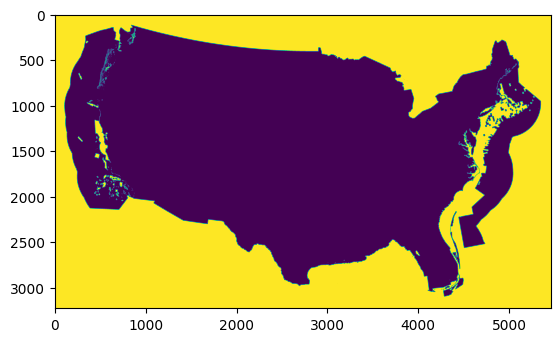

In [5]:
# Adjust offshore environmental areas to not exclude land areas
offshore_raster = ['gridcerf_noaa_habitats_of_particular_concern.tif',
                   'gridcerf_noaa_marine_sanctuaries.tif',
                   'gridcerf_offshore_areas_withdrawn_from_leasing.tif']

for r in offshore_raster:
    file_path = os.path.join(technology_specific_dir, r)
    array = rasterio.open(file_path).read(1)
    conus = rasterio.open(land_mask_file_0).read(1)
    array = array*conus
    if offshore_raster[0] == r:
        combo_offshore = array
    else:
        combo_offshore = combo_offshore + array
combo_offshore = np.where(combo_offshore>=1, 1, 0)
show(combo_offshore)

with rasterio.open(siting_mask_file_1) as template:

    metadata = template.meta.copy()

target_layer = 'gridcerf_combined_offshore_environment.tif'

# write compiled file
output_file = os.path.join(technology_specific_dir, target_layer)
with rasterio.open(output_file, 'w', **metadata) as dest:
    dest.write(combo_offshore.astype(np.int16), 1)

### Level 1 Environmental Area Layers

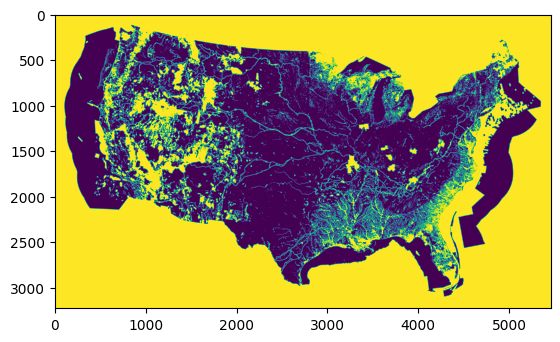

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_1.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_1.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/inpu

In [16]:
raster_dict_level_1 = {'common': ['gridcerf_usfs_national_wild_scenic_river_system_conus.tif',
                'gridcerf_blm_nlcs_national_monument_conus.tif',
                'gridcerf_blm_nlcs_wilderness_conus.tif',
                'gridcerf_usfws_critical_habitat_conus.tif',
                'gridcerf_wdpa_tnc_managed_lands_conus.tif',
                'gridcerf_blm_historic_parks.tif',
                'gridcerf_nps_historic_trails_conus.tif',
                'gridcerf_usfs_wilderness_areas_conus.tif',
                'gridcerf_usfs_national_designated_areas_conus.tif',
                'gridcerf_usfws_special_designation_conus.tif',
                'gridcerf_blm_areas_of_critical_environmental_concern.tif',
                'gridcerf_usgs_padus_class_1_to_2_conus_additions.tif',
                'gridcerf_nlcd_wetlands_conus.tif',
                'gridcerf_blm_drecp_wildlife_allocation.tif',
                'gridcerf_nps_administrative_boundaries_conus.tif',
                'gridcerf_blm_national_register_property.tif',
                'gridcerf_usgs_lakes_reservoirs.tif',
                'gridcerf_bor_surface_management_agency_areas.tif',
                'gridcerf_nps_scenic_trails_conus.tif',
                'gridcerf_blm_nlcs_wilderness_study_areas_conus.tif',
                'gridcerf_blm_historic_landmarks.tif'],
            'technology_specific':[
                'gridcerf_combined_offshore_environment.tif',
                'gridcerf_blm_grsg_phma_exclusion.tif',
                'gridcerf_blm_grsg_sfa_exclusion.tif',
                'gridcerf_blm_lands_acquired_for_conservation.tif',
                'gridcerf_blm_row_exclusion_area.tif',
                'gridcerf_blm_drecp_srma.tif',
                'gridcerf_blm_srma_california.tif',
                'gridcerf_blm_drecp_national_conservation_lands.tif',
                'gridcerf_blm_lands_managed_for_wilderness_character.tif',
                'gridcerf_blm_national_conservation_area.tif',
                'gridcerf_blm_drecp_nscma.tif',
                'gridcerf_blm_vrm_class_I.tif',
                'gridcerf_blm_az_recreational_facilities.tif',
                'gridcerf_blm_srma_exclude_nevada_yuma_east.tif',
                'gridcerf_blm_peis_supplemental_exclusions.tif',
                'gridcerf_blm_ca_desert_wildlife_management_areas.tif',
                'gridcerf_blm_flat_tailed_horned_lizard_habitat.tif',
                'gridcerf_blm_fringe_toed_lizard_habitat.tif',
                'gridcerf_blm_mojave_ground_squirrel_habitat.tif',
                'gridcerf_blm_sage_grouse_habitat.tif',
                'gridcerf_blm_nv_instant_study_areas.tif',
            ]}

combined_file_name = 'gridcerf_combined_environment_level_1.tif'
combined_output_raster = os.path.join(technology_specific_dir, combined_file_name)

raster_dict = raster_dict_level_1

for file_type in raster_dict:
    for file in raster_dict[file_type]:
        if file_type == 'common':
            file_path = os.path.join(common_dir, file)
        else:
            file_path = os.path.join(technology_specific_dir, file)
            
        # open the template raster and extract metadata and land mask
        with rasterio.open(os.path.join(common_dir, raster_dict['common'][0])) as template:
    
            metadata = template.meta.copy()
            
        array = rasterio.open(file_path).read(1)

        if raster_dict['common'][0] == file:
            combined_array = array
        else:
            combined_array = combined_array + array

        combined_array = np.where(combined_array >=1, 1, 0)
        
# write output raster
with rasterio.open(combined_output_raster, 'w+', **metadata) as out:

    out.write_band(1, combined_array.astype(np.int16))
show(combined_array)


# clip and save to folders
input_file_path = os.path.join(technology_specific_dir, combined_file_name)

land_output_raster_path = os.path.join(land_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

all_area_output_raster_path = os.path.join(all_area_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

#### Buffered Level 1 Area

In [8]:
# full conus file as input
file = 'gridcerf_combined_environment_level_1.tif'

buffer_list = [1, 5, 10]
for buffer_size in buffer_list:
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=land_raster_output_dir, 
                            output_dir = land_raster_output_dir)
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=all_area_raster_output_dir, 
                            output_dir = all_area_raster_output_dir)

### Level 2 Environmental Area Layers

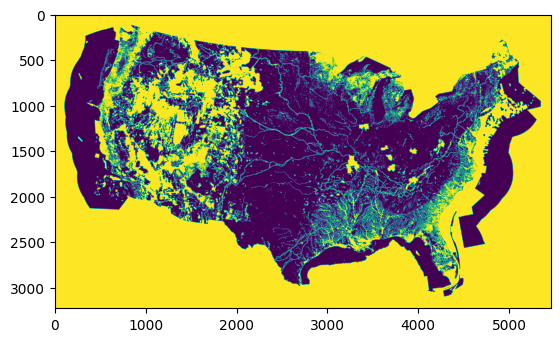

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_2.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_2.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/inpu

In [18]:
raster_dict_level_2 = {'common': ['gridcerf_usfs_national_wild_scenic_river_system_conus.tif',
                'gridcerf_blm_nlcs_national_monument_conus.tif',
                'gridcerf_blm_nlcs_wilderness_conus.tif',
                'gridcerf_usfws_critical_habitat_conus.tif',
                'gridcerf_wdpa_tnc_managed_lands_conus.tif',
                'gridcerf_blm_historic_parks.tif',
                'gridcerf_nps_historic_trails_conus.tif',
                'gridcerf_usfs_wilderness_areas_conus.tif',
                'gridcerf_usfs_national_designated_areas_conus.tif',
                'gridcerf_usfws_special_designation_conus.tif',
                'gridcerf_blm_areas_of_critical_environmental_concern.tif',
                'gridcerf_usgs_padus_class_1_to_2_conus_additions.tif',
                'gridcerf_nlcd_wetlands_conus.tif',
                'gridcerf_blm_drecp_wildlife_allocation.tif',
                'gridcerf_nps_administrative_boundaries_conus.tif',
                'gridcerf_blm_national_register_property.tif',
                'gridcerf_usgs_lakes_reservoirs.tif',
                'gridcerf_bor_surface_management_agency_areas.tif',
                'gridcerf_nps_scenic_trails_conus.tif',
                'gridcerf_blm_nlcs_wilderness_study_areas_conus.tif',
                'gridcerf_blm_historic_landmarks.tif'],
            'technology_specific':[

                # excluded areas
                
                'gridcerf_combined_offshore_environment.tif',
                'gridcerf_blm_grsg_phma_exclusion.tif',
                'gridcerf_blm_grsg_sfa_exclusion.tif',
                'gridcerf_blm_lands_acquired_for_conservation.tif',
                'gridcerf_blm_row_exclusion_area.tif',
                'gridcerf_blm_drecp_srma.tif',
                'gridcerf_blm_srma_california.tif',
                'gridcerf_blm_drecp_national_conservation_lands.tif',
                'gridcerf_blm_lands_managed_for_wilderness_character.tif',
                'gridcerf_blm_national_conservation_area.tif',
                'gridcerf_blm_drecp_nscma.tif',
                'gridcerf_blm_vrm_class_I.tif',
                'gridcerf_blm_az_recreational_facilities.tif',
                'gridcerf_blm_srma_exclude_nevada_yuma_east.tif',
                'gridcerf_blm_peis_supplemental_exclusions.tif',
                'gridcerf_blm_ca_desert_wildlife_management_areas.tif',
                'gridcerf_blm_flat_tailed_horned_lizard_habitat.tif',
                'gridcerf_blm_fringe_toed_lizard_habitat.tif',
                'gridcerf_blm_mojave_ground_squirrel_habitat.tif',
                'gridcerf_blm_sage_grouse_habitat.tif',
                'gridcerf_blm_nv_instant_study_areas.tif',

                # additional high risk areas

                'gridcerf_blm_ca_condor_critical.tif',
                'gridcerf_blm_ca_condor_d.tif',
                'gridcerf_blm_desert_tortoise_designated_critical_habitat.tif',
                'gridcerf_blm_m_s_owl_critical.tif',
                'gridcerf_blm_m_s_owl_d.tif',
                'gridcerf_blm_n_s_owl_critical.tif',
                'gridcerf_blm_n_s_owl_d.tif',
                'gridcerf_blm_grsg_ghma_hlsc.tif',
                'gridcerf_blm_grsg_phma_hlsc.tif',
                'gridcerf_blm_grsg_sfa_hlsc.tif',
                'gridcerf_blm_nso_restriction.tif',
                'gridcerf_blm_row_avoidance_area.tif',
                'gridcerf_blm_uttr.tif',
                'gridcerf_blm_drecp_erma.tif',
                'gridcerf_blm_vrm_class_II.tif'
            ]}

combined_file_name = 'gridcerf_combined_environment_level_2.tif'
combined_output_raster = os.path.join(technology_specific_dir, combined_file_name)

raster_dict = raster_dict_level_2

for file_type in raster_dict:
    for file in raster_dict[file_type]:
        if file_type == 'common':
            file_path = os.path.join(common_dir, file)
        else:
            file_path = os.path.join(technology_specific_dir, file)
            
        # open the template raster and extract metadata and land mask
        with rasterio.open(os.path.join(common_dir, raster_dict['common'][0])) as template:
    
            metadata = template.meta.copy()
            
        array = rasterio.open(file_path).read(1)

        if raster_dict['common'][0] == file:
            combined_array = array
        else:
            combined_array = combined_array + array

        combined_array = np.where(combined_array >=1, 1, 0)
        
# write output raster
with rasterio.open(combined_output_raster, 'w+', **metadata) as out:

    out.write_band(1, combined_array.astype(np.int16))
show(combined_array)


# clip and save to folders
input_file_path = os.path.join(technology_specific_dir, combined_file_name)

land_output_raster_path = os.path.join(land_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

all_area_output_raster_path = os.path.join(all_area_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

#### Level 2 Buffered Area

In [19]:
# full conus file as input
file = 'gridcerf_combined_environment_level_2.tif'

buffer_list = [1, 5, 10]
for buffer_size in buffer_list:
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=land_raster_output_dir, 
                            output_dir = land_raster_output_dir)
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=all_area_raster_output_dir, 
                            output_dir = all_area_raster_output_dir)

### Level 3 Environment Areas

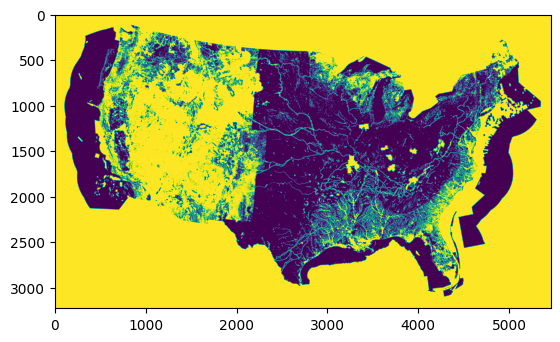

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_3.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/gridcerf/data/technology_specific/gridcerf_combined_environment_level_3.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/inpu

In [20]:
raster_dict_level_3 = {'common': ['gridcerf_usfs_national_wild_scenic_river_system_conus.tif',
                'gridcerf_blm_nlcs_national_monument_conus.tif',
                'gridcerf_blm_nlcs_wilderness_conus.tif',
                'gridcerf_usfws_critical_habitat_conus.tif',
                'gridcerf_wdpa_tnc_managed_lands_conus.tif',
                'gridcerf_blm_historic_parks.tif',
                'gridcerf_nps_historic_trails_conus.tif',
                'gridcerf_usfs_wilderness_areas_conus.tif',
                'gridcerf_usfs_national_designated_areas_conus.tif',
                'gridcerf_usfws_special_designation_conus.tif',
                'gridcerf_blm_areas_of_critical_environmental_concern.tif',
                'gridcerf_usgs_padus_class_1_to_2_conus_additions.tif',
                'gridcerf_nlcd_wetlands_conus.tif',
                'gridcerf_blm_drecp_wildlife_allocation.tif',
                'gridcerf_nps_administrative_boundaries_conus.tif',
                'gridcerf_blm_national_register_property.tif',
                'gridcerf_usgs_lakes_reservoirs.tif',
                'gridcerf_bor_surface_management_agency_areas.tif',
                'gridcerf_nps_scenic_trails_conus.tif',
                'gridcerf_blm_nlcs_wilderness_study_areas_conus.tif',
                'gridcerf_blm_historic_landmarks.tif'],
            
            'technology_specific':[

                # excluded areas
                
                'gridcerf_combined_offshore_environment.tif',
                'gridcerf_blm_grsg_phma_exclusion.tif',
                'gridcerf_blm_grsg_sfa_exclusion.tif',
                'gridcerf_blm_lands_acquired_for_conservation.tif',
                'gridcerf_blm_row_exclusion_area.tif',
                'gridcerf_blm_drecp_srma.tif',
                'gridcerf_blm_srma_california.tif',
                'gridcerf_blm_drecp_national_conservation_lands.tif',
                'gridcerf_blm_lands_managed_for_wilderness_character.tif',
                'gridcerf_blm_national_conservation_area.tif',
                'gridcerf_blm_drecp_nscma.tif',
                'gridcerf_blm_vrm_class_I.tif',
                'gridcerf_blm_az_recreational_facilities.tif',
                'gridcerf_blm_srma_exclude_nevada_yuma_east.tif',
                'gridcerf_blm_peis_supplemental_exclusions.tif',
                'gridcerf_blm_ca_desert_wildlife_management_areas.tif',
                'gridcerf_blm_flat_tailed_horned_lizard_habitat.tif',
                'gridcerf_blm_fringe_toed_lizard_habitat.tif',
                'gridcerf_blm_mojave_ground_squirrel_habitat.tif',
                'gridcerf_blm_sage_grouse_habitat.tif',
                'gridcerf_blm_nv_instant_study_areas.tif',

                # high risk areas

                'gridcerf_blm_ca_condor_critical.tif',
                'gridcerf_blm_ca_condor_d.tif',
                'gridcerf_blm_desert_tortoise_designated_critical_habitat.tif',
                'gridcerf_blm_m_s_owl_critical.tif',
                'gridcerf_blm_m_s_owl_d.tif',
                'gridcerf_blm_n_s_owl_critical.tif',
                'gridcerf_blm_n_s_owl_d.tif',
                'gridcerf_blm_grsg_ghma_hlsc.tif',
                'gridcerf_blm_grsg_phma_hlsc.tif',
                'gridcerf_blm_grsg_sfa_hlsc.tif',
                'gridcerf_blm_nso_restriction.tif',
                'gridcerf_blm_row_avoidance_area.tif',
                'gridcerf_blm_uttr.tif',
                'gridcerf_blm_drecp_erma.tif',
                'gridcerf_blm_vrm_class_II.tif',
                
                
                # moderate risk areas
                
                'gridcerf_blm_ap_falcon_d.tif',
                'gridcerf_blm_b_eagle_d.tif',
                'gridcerf_blm_desert_wildlife_management_areas.tif',
                'gridcerf_blm_designated_special_status_species_management_areas.tif',
                'gridcerf_blm_desert_tortoise_connectivity_area.tif',
                'gridcerf_blm_g_eagle_d.tif',
                'gridcerf_blm_grsg_ghma_mlsc.tif',
                'gridcerf_blm_sharp_tailed_grouse_habitat.tif',
                'gridcerf_blm_wildlife_management_area.tif',
                'gridcerf_blm_land_purchased_w_private_funds.tif',
                'gridcerf_blm_long_term_visitor_use_areas.tif',
                'gridcerf_blm_special_recreation_management_area.tif',
                'gridcerf_blm_back_country_byways.tif',
                'gridcerf_blm_national_scenic_highways.tif',
                'gridcerf_blm_state_scenic_highways.tif',
                'gridcerf_blm_vrm_class_III.tif'

            ]}
combined_file_name = 'gridcerf_combined_environment_level_3.tif'
combined_output_raster = os.path.join(technology_specific_dir, combined_file_name)

raster_dict = raster_dict_level_3

for file_type in raster_dict:
    for file in raster_dict[file_type]:
        if file_type == 'common':
            file_path = os.path.join(common_dir, file)
        else:
            file_path = os.path.join(technology_specific_dir, file)
            
        # open the template raster and extract metadata and land mask
        with rasterio.open(os.path.join(common_dir, raster_dict['common'][0])) as template:
    
            metadata = template.meta.copy()
            
        array = rasterio.open(file_path).read(1)

        if raster_dict['common'][0] == file:
            combined_array = array
        else:
            combined_array = combined_array + array

        combined_array = np.where(combined_array >=1, 1, 0)
        
# write output raster
with rasterio.open(combined_output_raster, 'w+', **metadata) as out:

    out.write_band(1, combined_array.astype(np.int16))
show(combined_array)


# clip and save to folders
input_file_path = os.path.join(technology_specific_dir, combined_file_name)

land_output_raster_path = os.path.join(land_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

all_area_output_raster_path = os.path.join(all_area_raster_output_dir, combined_file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

#### Level 3 Buffered Area

In [21]:
# full conus file as input
file = 'gridcerf_combined_environment_level_3.tif'

buffer_list = [1, 5, 10]
for buffer_size in buffer_list:
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=land_raster_output_dir, 
                            output_dir = land_raster_output_dir)
    apply_raster_buffer(buffer_size=buffer_size, raster_file=file, 
                            input_dir=all_area_raster_output_dir, 
                            output_dir = all_area_raster_output_dir)

# Onshore Wind Suitability
Without resource potential restrictions

In [17]:
wind_suitability_rasters={
    'common': ['gridcerf_blm_nlcs_national_monument_conus',
          'gridcerf_blm_nlcs_wilderness_conus',
          'gridcerf_blm_nlcs_wilderness_study_areas_conus',
          'gridcerf_nps_administrative_boundaries_conus',
          'gridcerf_nps_historic_trails_conus',
          'gridcerf_nps_scenic_trails_conus',
          'gridcerf_usfs_national_wild_scenic_river_system_conus',
          'gridcerf_usfs_national_designated_areas_conus',
          'gridcerf_usfs_wilderness_areas_conus',
          'gridcerf_dod_military_installations_conus',
          'gridcerf_usfws_critical_habitat_conus',
          'gridcerf_usfws_special_designation_conus',
          'gridcerf_nlcd_wetlands_conus',
          'gridcerf_usgs_padus_class_1_to_2_conus_additions',
          'gridcerf_wdpa_tnc_managed_lands_conus',
          'gridcerf_usgs_lakes_reservoirs',
          'gridcerf_blm_areas_of_critical_environmental_concern',
          'gridcerf_blm_historic_parks',
          'gridcerf_blm_historic_landmarks',
          'gridcerf_blm_national_register_property',
          'gridcerf_blm_drecp_wildlife_allocation'],
         'reference': ['gridcerf_landmask_0-land'],
         'technology_specific': [
             'gridcerf_state_level_wind_exclusions',
          'gridcerf_airports_faa_7km_buffer_conus',
          'gridcerf_srtm_slope_20pct_or_less',
          'gridcerf_noaa_radar_stations_5mi_buffer',
          'gridcerf_blm_grsg_phma_exclusion',
          'gridcerf_blm_grsg_sfa_exclusion',
          'gridcerf_blm_drecp_dfa_solar_geothermal',
          'gridcerf_blm_lands_acquired_for_conservation',
          'gridcerf_blm_wind_exclusion_area',
          'gridcerf_blm_row_exclusion_area',
          'gridcerf_blm_off_highway_vehicle_areas',
          'gridcerf_blm_special_recreation_management_area',
          'gridcerf_blm_srma_california',
          'gridcerf_blm_drecp_national_conservation_lands',
          'gridcerf_blm_lands_managed_for_wilderness_character',
          'gridcerf_blm_national_conservation_area',
          'gridcerf_blm_drecp_nscma',
          'gridcerf_blm_vrm_class_I'],
         'scenario_specific': ['gridcerf_population_ssp2_2050_1km_conus_50k_per25sqmi']}
wind_suitability_rasters={
    'common': [
        'gridcerf_blm_nlcs_national_monument_conus.tif',
        'gridcerf_blm_nlcs_wilderness_conus.tif',
        'gridcerf_blm_nlcs_wilderness_study_areas_conus.tif',
        'gridcerf_nps_administrative_boundaries_conus.tif',
        'gridcerf_nps_historic_trails_conus.tif',
        'gridcerf_nps_scenic_trails_conus.tif',
        'gridcerf_usfs_national_wild_scenic_river_system_conus.tif',
        'gridcerf_usfs_national_designated_areas_conus.tif',
        'gridcerf_usfs_wilderness_areas_conus.tif',
        'gridcerf_dod_military_installations_conus.tif',
        'gridcerf_epa_class1_airsheds_conus.tif',
        'gridcerf_usfws_critical_habitat_conus.tif',
        'gridcerf_usfws_special_designation_conus.tif',
        'gridcerf_nlcd_wetlands_conus.tif',
        'gridcerf_usgs_padus_class_1_to_2_conus_additions.tif',
        'gridcerf_wdpa_tnc_managed_lands_conus.tif',
        'gridcerf_usgs_lakes_reservoirs.tif',
        'gridcerf_blm_areas_of_critical_environmental_concern.tif',
        'gridcerf_blm_historic_parks.tif',
        'gridcerf_blm_historic_landmarks.tif',
        'gridcerf_blm_national_register_property.tif',
        'gridcerf_blm_drecp_wildlife_allocation.tif'],
    'reference': ['gridcerf_landmask_0-land.tif'],
    'technology_specific': ['gridcerf_state_level_wind_exclusions.tif',
        'gridcerf_airports_faa_8km_buffer_conus.tif',
        'gridcerf_srtm_slope_20pct_or_less.tif',
        'gridcerf_noaa_radar_stations_5mi_buffer.tif',
        'gridcerf_bia_land_area_representations_conus.tif',
        'gridcerf_blm_grsg_phma_exclusion.tif',
        'gridcerf_blm_grsg_sfa_exclusion.tif',
        'gridcerf_blm_drecp_dfa_solar_geothermal.tif',
        'gridcerf_blm_lands_acquired_for_conservation.tif',
        'gridcerf_blm_wind_exclusion_area.tif',
        'gridcerf_blm_row_exclusion_area.tif',
        'gridcerf_blm_off_highway_vehicle_areas.tif',
        'gridcerf_blm_special_recreation_management_area.tif',
        'gridcerf_blm_srma_california.tif',
        'gridcerf_blm_drecp_national_conservation_lands.tif',
        'gridcerf_blm_lands_managed_for_wilderness_character.tif',
        'gridcerf_blm_national_conservation_area.tif',
        'gridcerf_blm_drecp_nscma.tif',
        'gridcerf_blm_vrm_class_I.tif'], 
    'scenario_specific': ['gridcerf_population_ssp2_2050_1km_conus_50k_per25sqmi.tif']}

In [18]:
siting_mask_file_1 = os.path.join(reference_dir, "gridcerf_sitingmask.tif")
siting_mask_file_0 = os.path.join(reference_dir, "gridcerf_sitingmask_0-value.tif")

compile_list = []
for layer_type in wind_suitability_rasters:
    for layer in wind_suitability_rasters[layer_type]:

        layer_path = os.path.join(gridcerf_dir, layer_type, f'{layer}')
        compile_list.append(layer_path)

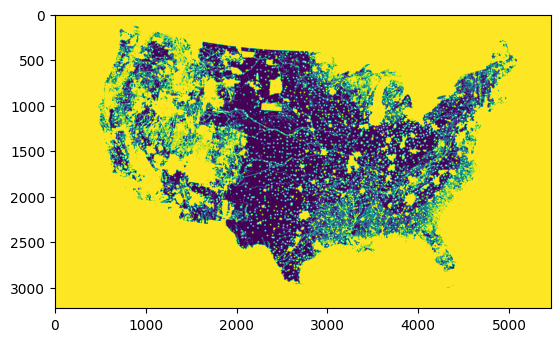

<Axes: >

In [19]:
land_mask_0 = rasterio.open(siting_mask_file_0).read(1)

with rasterio.open(siting_mask_file_1) as template:

    metadata = template.meta.copy()

    land_mask_1 = template.read(1)

    for index, i in enumerate(compile_list):

        with rasterio.open(i) as src:

            if index == 0:
                arr = src.read(1).astype(np.int64)
            else:
                arr += src.read(1).astype(np.int64)

        # adjust to binary suitability with nodata set to 3 for uint8 storage
        arr = np.where(arr == 0, 0, 1)

        # apply land mask
        arr *= land_mask_1

        arr += land_mask_0
# write compiled file
output_file = os.path.join(processed_raster_dir, 'gridcerf_wind_suitability_100m_hubheight.tif')
with rasterio.open(output_file, 'w', **metadata) as dest:
    dest.write(arr.astype(np.int16), 1)
show(arr)

In [20]:
# clip and save to folders
file_name = f'gridcerf_wind_suitability_100m_hubheight.tif'
input_file_path = os.path.join(processed_raster_dir,file_name)

land_output_raster_path = os.path.join(land_raster_output_dir, file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

all_area_output_raster_path = os.path.join(all_area_raster_output_dir, file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/compiled_raster_data/gridcerf_wind_suitability_100m_hubheight.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/compiled_raster_data/gridcerf_wind_suitability_100m_hubheight.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /

# Solar PV Suitability

All restrictions with no resource potential restrictions

In [26]:

solar_suitability_rasters={'common': ['gridcerf_blm_nlcs_national_monument_conus',
  'gridcerf_blm_nlcs_wilderness_conus',
  'gridcerf_blm_nlcs_wilderness_study_areas_conus',
  'gridcerf_nps_administrative_boundaries_conus',
  'gridcerf_nps_historic_trails_conus',
  'gridcerf_nps_scenic_trails_conus',
  'gridcerf_usfs_national_wild_scenic_river_system_conus',
  'gridcerf_usfs_national_designated_areas_conus',
  'gridcerf_usfs_wilderness_areas_conus',
  'gridcerf_dod_military_installations_conus',
  'gridcerf_usfws_critical_habitat_conus',
  'gridcerf_usfws_special_designation_conus',
  'gridcerf_nlcd_wetlands_conus',
  'gridcerf_usgs_padus_class_1_to_2_conus_additions',
  'gridcerf_wdpa_tnc_managed_lands_conus',
  'gridcerf_usgs_lakes_reservoirs',
  'gridcerf_blm_areas_of_critical_environmental_concern',
  'gridcerf_blm_historic_parks',
  'gridcerf_blm_historic_landmarks',
  'gridcerf_blm_national_register_property',
  'gridcerf_blm_drecp_wildlife_allocation'],
 'reference': ['gridcerf_landmask_0-land'],
 'technology_specific': ['gridcerf_state_level_solar_exclusions',
  'gridcerf_airports_faa_no_buffer_conus',
  'gridcerf_srtm_slope_10pct_or_less',
  'gridcerf_blm_lands_acquired_for_conservation',
  'gridcerf_blm_row_avoidance_area',
  'gridcerf_blm_row_exclusion_area',
  'gridcerf_blm_off_highway_vehicle_areas',
  'gridcerf_blm_drecp_national_conservation_lands',
  'gridcerf_blm_lands_managed_for_wilderness_character',
  'gridcerf_blm_national_conservation_area',
  'gridcerf_blm_back_country_byways',
  'gridcerf_blm_drecp_nscma',
  'gridcerf_blm_vrm_class_I',
  'gridcerf_blm_vrm_class_II',
  'gridcerf_blm_az_recreational_facilities',
  'gridcerf_blm_srma_exclude_nevada_yuma_east',
  'gridcerf_blm_peis_supplemental_exclusions',
  'gridcerf_blm_solar_energy_zone_exclusions',
  'gridcerf_blm_ca_desert_wildlife_management_areas',
  'gridcerf_blm_flat_tailed_horned_lizard_habitat',
  'gridcerf_blm_fringe_toed_lizard_habitat',
  'gridcerf_blm_mojave_ground_squirrel_habitat',
  'gridcerf_blm_sage_grouse_habitat',
  'gridcerf_blm_ivanpah_valley_exclusions',
  'gridcerf_blm_garden_coal_valley_exclusions',
  'gridcerf_blm_nv_instant_study_areas'],
 'scenario_specific': ['gridcerf_population_ssp2_2050_1km_conus_50k_per25sqmi']}


solar_suitability_rasters={
    'common': ['gridcerf_blm_nlcs_national_monument_conus.tif',
        'gridcerf_blm_nlcs_wilderness_conus.tif',
        'gridcerf_blm_nlcs_wilderness_study_areas_conus.tif',
        'gridcerf_nps_administrative_boundaries_conus.tif',
        'gridcerf_nps_historic_trails_conus.tif',
        'gridcerf_nps_scenic_trails_conus.tif',
        'gridcerf_usfs_national_wild_scenic_river_system_conus.tif',
        'gridcerf_usfs_national_designated_areas_conus.tif',
        'gridcerf_usfs_wilderness_areas_conus.tif',
        'gridcerf_dod_military_installations_conus.tif',
        'gridcerf_epa_class1_airsheds_conus.tif',
        'gridcerf_usfws_critical_habitat_conus.tif',
        'gridcerf_usfws_special_designation_conus.tif',
        'gridcerf_nlcd_wetlands_conus.tif',
        'gridcerf_usgs_padus_class_1_to_2_conus_additions.tif',
        'gridcerf_wdpa_tnc_managed_lands_conus.tif',
        'gridcerf_usgs_lakes_reservoirs.tif',
        'gridcerf_blm_areas_of_critical_environmental_concern.tif',
        'gridcerf_blm_historic_parks.tif',
        'gridcerf_blm_historic_landmarks.tif',
        'gridcerf_blm_national_register_property.tif',
        'gridcerf_blm_drecp_wildlife_allocation.tif'],
     'reference': ['gridcerf_landmask_0-land.tif'],
     'technology_specific': [
        'gridcerf_state_level_solar_exclusions.tif',
        'gridcerf_airports_faa_no_buffer_conus.tif',
        'gridcerf_srtm_slope_10pct_or_less.tif',
        'gridcerf_bia_land_area_representations_conus.tif',
        'gridcerf_fema_1pct_or_greater_inland_flood_risk.tif',
        'gridcerf_fema_1pct_or_greater_coastal_flood_risk.tif',
        'gridcerf_blm_lands_acquired_for_conservation.tif',
        'gridcerf_blm_row_avoidance_area.tif',
        'gridcerf_blm_row_exclusion_area.tif',
        'gridcerf_blm_off_highway_vehicle_areas.tif',
        'gridcerf_blm_drecp_national_conservation_lands.tif',
        'gridcerf_blm_lands_managed_for_wilderness_character.tif',
        'gridcerf_blm_national_conservation_area.tif',
        'gridcerf_blm_back_country_byways.tif',
        'gridcerf_blm_drecp_nscma.tif',
        'gridcerf_blm_vrm_class_I.tif',
        'gridcerf_blm_vrm_class_II.tif',
        'gridcerf_blm_az_recreational_facilities.tif',
        'gridcerf_blm_srma_exclude_nevada_yuma_east.tif',
        'gridcerf_blm_peis_supplemental_exclusions.tif',
        'gridcerf_blm_solar_energy_zone_exclusions.tif',
        'gridcerf_blm_ca_desert_wildlife_management_areas.tif',
        'gridcerf_blm_flat_tailed_horned_lizard_habitat.tif',
        'gridcerf_blm_fringe_toed_lizard_habitat.tif',
        'gridcerf_blm_mojave_ground_squirrel_habitat.tif',
        'gridcerf_blm_sage_grouse_habitat.tif',
        'gridcerf_blm_ivanpah_valley_exclusions.tif',
        'gridcerf_blm_garden_coal_valley_exclusions.tif',
        'gridcerf_blm_nv_instant_study_areas.tif'],
     'scenario_specific': ['gridcerf_population_ssp2_2050_1km_conus_50k_per25sqmi.tif']}

In [27]:
siting_mask_file_1 = os.path.join(reference_dir, "gridcerf_sitingmask.tif")
siting_mask_file_0 = os.path.join(reference_dir, "gridcerf_sitingmask_0-value.tif")

compile_list = []
for layer_type in solar_suitability_rasters:
    for layer in solar_suitability_rasters[layer_type]:

        layer_path = os.path.join(gridcerf_dir, layer_type, f'{layer}')
        compile_list.append(layer_path)

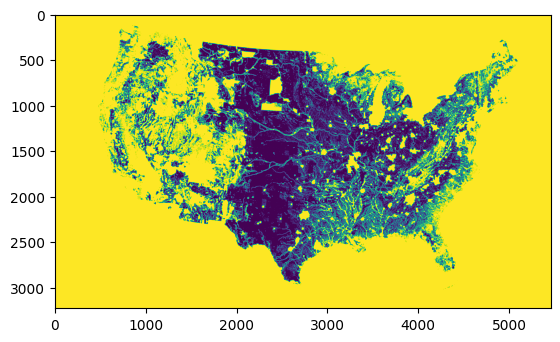

<Axes: >

In [28]:
land_mask_0 = rasterio.open(siting_mask_file_0).read(1)

with rasterio.open(siting_mask_file_1) as template:

    metadata = template.meta.copy()

    land_mask_1 = template.read(1)

    for index, i in enumerate(compile_list):

        with rasterio.open(i) as src:

            if index == 0:
                arr = src.read(1).astype(np.int64)
            else:
                arr += src.read(1).astype(np.int64)

        # adjust to binary suitability
        arr = np.where(arr == 0, 0, 1)

        # apply land mask
        arr *= land_mask_1

        arr += land_mask_0
# write compiled file
output_file = os.path.join(processed_raster_dir, 'gridcerf_solar_pv_suitability.tif')
with rasterio.open(output_file, 'w', **metadata) as dest:
    dest.write(arr.astype(np.int16), 1)
show(arr)

In [29]:
# clip and save to folders
file_name = f'gridcerf_solar_pv_suitability.tif'
input_file_path = os.path.join(processed_raster_dir,file_name)

land_output_raster_path = os.path.join(land_raster_output_dir, file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

all_area_output_raster_path = os.path.join(all_area_raster_output_dir, file_name)
clip_raster(input_raster_path=input_file_path, output_raster_path=all_area_output_raster_path, input_shp_path=wecc_all_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/compiled_raster_data/gridcerf_solar_pv_suitability.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/compiled_raster_data/gridcerf_solar_pv_suitability.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2221P x 2185L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/gr

# Prepare Wind and Solar Generation Potential

#### Function to process capacity factor data

In [32]:
def process_cf_data(cf_data_path, wrf_sample_path, tmp_dir, raster_output_path):

    """ Reads a netcdf file of hourly capacity factor data for a single year, sums the
    hourly capacity factor across the entire year of data for each grid cell, and then rasterizes
    the output to the albers equal area conic projection (ESRI:102003). The resulting file can be
    multiplied by any capacity (MW) power plant of the corresponding technology type to obtain total
    annual generation per grid cell."""
    
    # load the wrf sample data
    wrf = salem.open_wrf_dataset(wrf_sample)[['T2']].isel(time=0, drop=True)        
            
    # load the capacity factor data
    data = xr.open_dataset(fn).load()
    
    # fix times
    data['Time'] = pd.DatetimeIndex(data['Time'].values)
    
    # create a new capacity factor variable in the sample dataset that creates the total capacity factor for the year
    wrf['capacity_factor'] = (('south_north', 'west_east'), (data['capacity_factor']).sum(dim='Time').values)
    
    # copy the attributes
    wrf['capacity_factor'].attrs = data['capacity_factor'].attrs

    # create path to temporary output raster
    tmp_path = os.path.join(tmp_dir, 'tmp.tif')
    
    # set crs, set spatial dims, write to raster
    wrf['capacity_factor'].rio.set_spatial_dims('west_east', 'south_north').rio.write_crs(wrf.pyproj_srs).rio.to_raster(tmp_path)
        
    gdal_warp_cmd = f"gdalwarp -te -2831615.228 -1539013.3223 2628318.0948 1690434.1707 -tr 1000.0 1000.0 -t_srs ESRI:102003 -dstnodata 0 -overwrite {tmp_path} {output_path}"
    os.system(gdal_warp_cmd)

    show(rasterio.open(output_path))

    return None


## Wind

In [34]:
data_dir

'/Users/mong275/repos/mongird-etal_2024_tbd/data'

In [37]:
# path to wind capacity factor net cdf file for 2050
fn = os.path.join(wind_cf_dir, 'wind_gen_cf_2050_100m.nc')

# path to wrf sample data for projection
wrf_sample = '/Volumes/godeeep/shared_data/tgw_wrf/tgw_wrf_historic/hourly/tgw_wrf_historic_hourly_2022-12-10_01_00_00.nc'

# tmp directory path
output_file_name='wind_100m_hubheight_2050_rcp85_potential.tif'

# output folder
tmp_dir = os.path.join(data_dir, 'input_data', 'tmp')
os.makedirs(tmp_dir, exist_ok=True)
    
# path to save output raster file
output_path = os.path.join(tmp_dir, f'wind_cf_albers.tif')

#### Process wind capacity factor raster

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/tmp.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


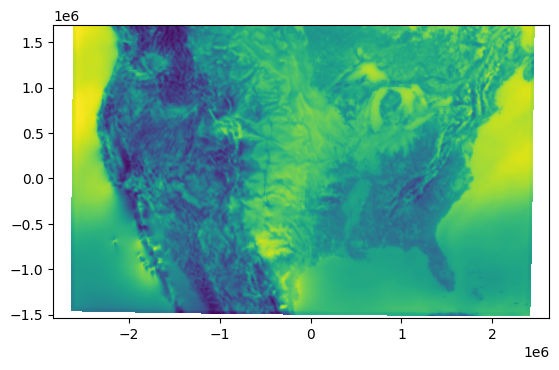

In [38]:
process_cf_data(cf_data_path = fn, wrf_sample_path=wrf_sample, tmp_dir=tmp_dir, raster_output_path = output_path)

#### Clip output raster to western interconnection extent

In [39]:
land_output_raster_path = os.path.join(land_raster_output_dir, output_file_name)

clip_raster(input_raster_path=output_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/sample_cf_albers.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/sample_cf_albers.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


#### Combine Wind Potential with Wind Exclusion Data and Save File

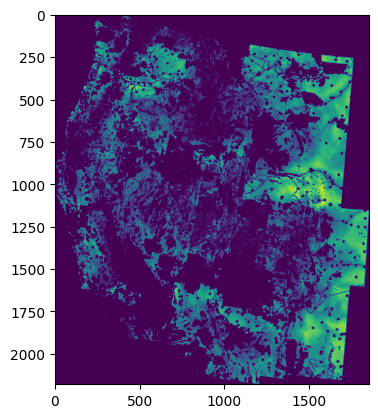

In [41]:
wind_exclusions = os.path.join(land_raster_output_dir, 'gridcerf_wind_suitability_100m_hubheight.tif')
wind_potential_file = os.path.join(land_raster_output_dir, 'wind_100m_hubheight_2050_rcp85_potential.tif')
output_file = os.path.join(land_raster_output_dir, 'wind_100m_hubheight_2050_rcp85_potential_base_exclusions.tif')

with rasterio.open(wind_exclusions) as template:

    metadata = template.meta.copy()
    metadata['dtype'] = np.float64
    wind_exc_array = template.read(1)
    wind_exc_array = np.where(wind_exc_array == 1, 0, 1)

    wind_pot_array = rasterio.open(wind_potential_file).read(1)
    wind_pot_array *= wind_exc_array

    with rasterio.open(output_file, 'w', **metadata) as dest:
        dest.write(wind_pot_array.astype(np.float64), 1)
        
    show(wind_pot_array)

## Solar

In [42]:
# path to wind capacity factor net cdf file for 2050
fn = os.path.join(solar_cf_dir, 'solar_gen_cf_2050.nc')

# path to wrf sample data for projection
wrf_sample = '/Volumes/godeeep/shared_data/tgw_wrf/tgw_wrf_historic/hourly/tgw_wrf_historic_hourly_2022-12-10_01_00_00.nc'

# tmp directory path
output_file_name='solar_2050_rcp85_potential.tif'

# output folder
tmp_dir = os.path.join(data_dir, 'input_data', 'tmp')
os.makedirs(tmp_dir, exist_ok=True)
    
# path to save output raster file
output_path = os.path.join(tmp_dir, f'solar_cf_albers.tif')

#### Process solar capacity factor raster

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/tmp.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


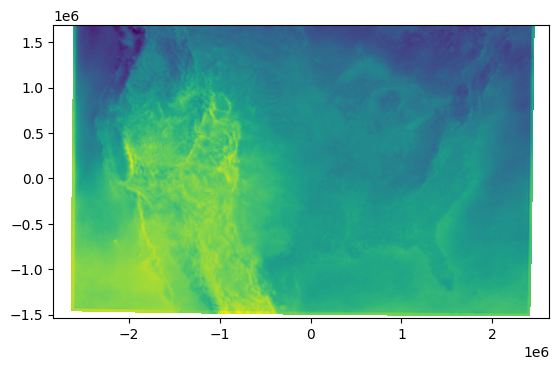

In [43]:
process_cf_data(cf_data_path = fn, wrf_sample_path=wrf_sample, tmp_dir=tmp_dir, raster_output_path = output_path)

#### Clip output raster to western interconnection extent

In [44]:
land_output_raster_path = os.path.join(land_raster_output_dir, output_file_name)

clip_raster(input_raster_path=output_path, output_raster_path=land_output_raster_path, input_shp_path=wecc_land_shp_path)

Creating output file that is 5460P x 3229L.
Processing /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/solar_cf_albers.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/mongird-etal_2024_tbd/data/input_data/tmp/solar_cf_albers.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1851P x 2180L.
Processing /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /Users/mong275/repos/gridcerf/data/gridcerf/technology_specific/tmp.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


#### Combine Solar Potential with Solar Exclusion Data and Save File

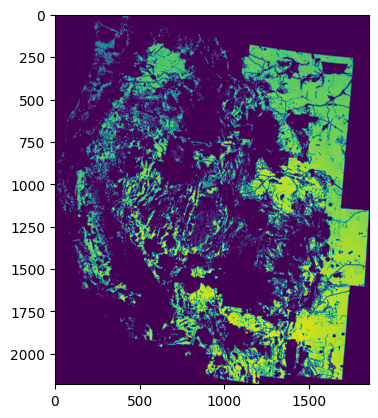

2726.8694


In [45]:
solar_exclusions = os.path.join(land_raster_output_dir, 'gridcerf_solar_pv_suitability.tif')
solar_potential_file = os.path.join(land_raster_output_dir, 'solar_2050_rcp85_potential.tif')
output_file = os.path.join(land_raster_output_dir, 'solar_pv_2050_rcp85_potential_base_exclusions.tif')

with rasterio.open(solar_exclusions) as template:

    metadata = template.meta.copy()
    metadata['dtype'] = np.float64
    solar_exc_array = template.read(1)
    solar_exc_array = np.where(solar_exc_array == 1, 0, 1)

    solar_pot_array = rasterio.open(solar_potential_file).read(1)
    solar_pot_array *= solar_exc_array

    with rasterio.open(output_file, 'w', **metadata) as dest:
        dest.write(solar_pot_array.astype(np.float64), 1)
        
    show(solar_pot_array)
    print(solar_pot_array.max())